In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [ ]:
#get max value of Radiation
max_radiation = df['Radiation'].max()
print(max_radiation)
#get min value of Radiation
min_radiation = df['Radiation'].min()
print(min_radiation)


In [ ]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df2 = df.sort_values('DateTime')
df2

In [ ]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




In [ ]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rad = df['Radiation']

plt.hist(rad, bins=100)
plt.show()

#log transform
rad_log = np.log(rad)
plt.hist(rad_log, bins=100)
plt.show()


## LSTM NN

In [3]:
import lstm
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        val_size=0.15,
        test_size=0.15,
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=True,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        use_log_transform=False, #figured out this one is super important
        use_power_transform=True,
        min_radiation_for_log=0.1,
        min_radiation_floor=0.01,
        clip_log_target=True,
        log_clip_lower_percentile=5,
        log_clip_upper_percentile=95,
        #min_target_threshold=1
)


Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Applying Yeo-Johnson Power Transform to 'Radiation'
Applying floor of 0.01 to 'Radiation' before Power Transform.
Yeo-Johnson applied (lambda=-0.1798). New target: 'Radiation_yeo'
Added 'Radiation_is_low' feature (threshold: 1.2000)
Using StandardScaler for feature scaling.
Using StandardScaler for Yeo-Johnson transformed target 'Radiation_yeo'.
DEBUG [PREPARE DATA]: Stats for target 'Radiation_yeo' BEFORE scaling: Mean=2.0463, Std=1.3787, Min=0.6987, Max=4.0863
DEBUG [PREPARE DATA]: Stats for target 'Radiation_yeo' AFTER scaling: Mean=0.0000, Std=1.0000, Min=-0.9774, Max=1.4797
DEBUG [PREPARE DATA]: Target Scaler learned mean: 2.0463, scale (std): 1.3787
X_train shape: (22862, 24, 18), y_train shape: (22862, 1)
X_val shape: (4900, 24, 18), y_val shape: (4900, 1)
X_test shape: (4900, 24, 18), y_test shape: (4900, 1)
Features used (18): ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDir

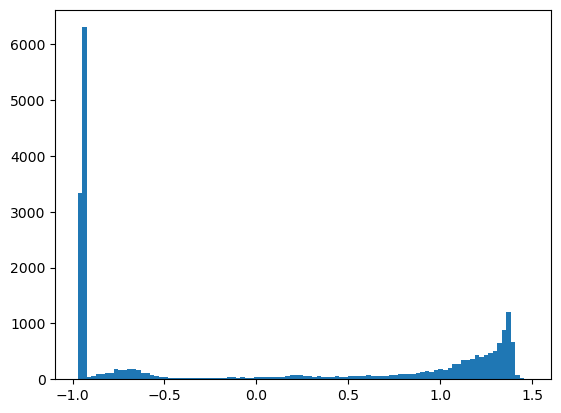

In [ ]:
#plot train vals
plt.hist(y_train, bins=100)
plt.show()


In [ ]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=10,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

In [4]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 128  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.9 #0.7
mape_weight=0.1 #0.3
dropout_prob =0.05
 
# Initialize model
device = torch.device('mps')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store complete transform info in the model
#model.transform_info = transform_info  # Store the whole transform_info object
    

In [5]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.0005, 
        patience=30,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=0.00001,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        loss_type='mse',#"value_aware",
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.1 #adjust
    )


X_train shape: (22862, 24, 18), y_train shape: (22862, 1)
X_val shape: (4900, 24, 18), y_val shape: (4900, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 0
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=100
Epoch 1/100 - Train loss: 0.056937 - Val loss: 0.042445 - Val RMSE: 0.206021 - Val R²: 0.951984 - Val MAPE: 9.03%
Epoch 2/100 - Train loss: 0.018248 - Val loss: 0.031484 - Val RMSE: 0.177439 - Val R²: 0.964383 - Val MAPE: 6.50%
Epoch 3/100 - Train loss: 0.016165 - Val loss: 0.032035 - Val RMSE: 0.178982 - Val R²: 0.963760 - Val MAPE: 7.14%
Epoch 4/100 - Train loss: 0.014420 - Val loss: 0.030286 - Val RMSE: 0.174027 - Val R²: 0.965739 - Val MAPE: 6.83%
Epoch 5/100 - Train loss: 0.013599 - Val loss: 0.030720 - Val RMSE: 0.175270 - Val R²: 0.965248 - Val MAPE: 6.53%
Epoch 6/100 - Train loss: 0.012991 - Val loss: 0.028889 - Val RMSE: 0.169969 - Val R²: 0.967318 - Val MAPE: 7.15%
Epoch 7/100 - Train lo

WeatherLSTM(
  (lstm): LSTM(18, 128, num_layers=2, batch_first=True, dropout=0.1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

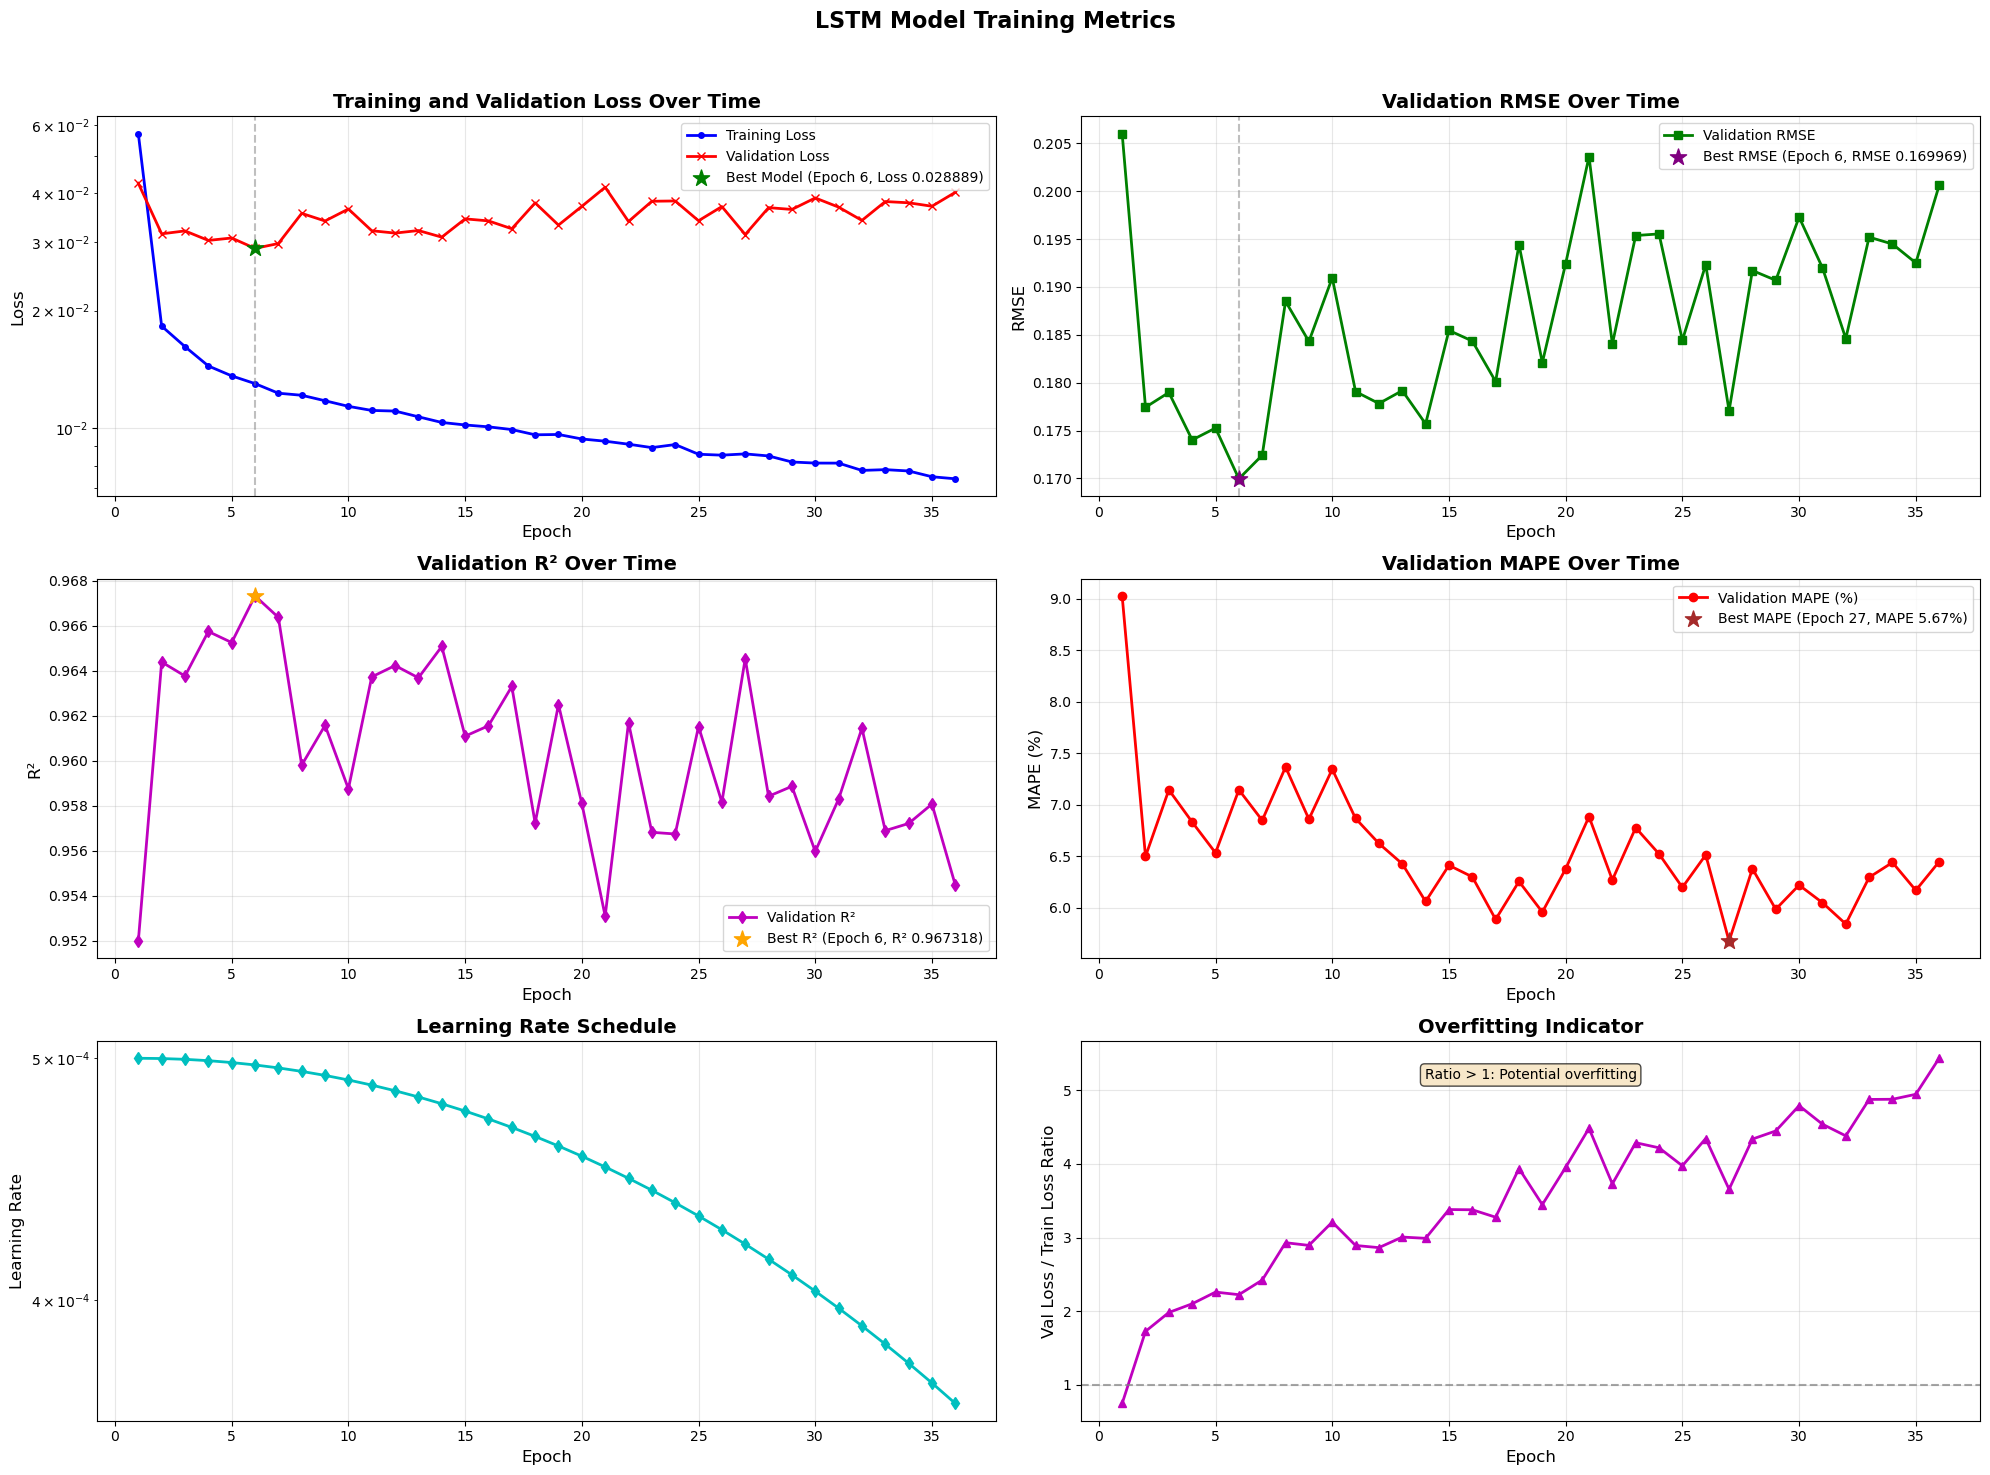

In [6]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = transform_info  # Store the whole transform_info object

In [7]:
print('transform_info', transform_info)
print('scalers', scalers)

transform_info {'transforms': [{'applied': True, 'type': 'yeo-johnson', 'lambda': -0.17977612569693133, 'original_col': 'Radiation', 'scaler_used_after': 'StandardScaler'}], 'target_col_original': 'Radiation', 'target_col_transformed_final': 'Radiation_yeo'}
scalers {'Radiation': StandardScaler(), 'Temperature': StandardScaler(), 'Pressure': StandardScaler(), 'Humidity': StandardScaler(), 'WindDirection(Degrees)': StandardScaler(), 'Speed': StandardScaler(), 'TimeMinutesSin': StandardScaler(), 'TimeMinutesCos': StandardScaler(), 'Radiation_is_low': StandardScaler(), 'SolarElevation': StandardScaler(), 'SunriseMinutes': StandardScaler(), 'SunsetMinutes': StandardScaler(), 'DaylightMinutes': StandardScaler(), 'TimeSinceSunrise': StandardScaler(), 'TimeUntilSunset': StandardScaler(), 'DaylightPosition': StandardScaler(), 'HourOfDay': StandardScaler(), 'IsDaylight': StandardScaler(), 'Radiation_yeo': StandardScaler(), 'power_transformer_object_for_target': PowerTransformer(standardize=Fals

DEBUG [EVALUATE]: Shape of actuals_std_log_np: (4900,)
DEBUG [EVALUATE]: Shape of model_predictions_std_log_np: (4900,)
DEBUG [EVALUATE]: Extracted std_dev_log for analysis: 1.3787

--- Analysis in Standardized Yeo-johnson Space ---
Number of samples: 4900
Mean of Residuals (Actuals - Predictions) in Standardized Yeo-johnson Space (K_prime): 0.0694
Std Dev of Residuals in Standardized Yeo-johnson Space: 0.2565
  Interpretation of a simple multiplicative factor (C) is specific to log transforms and not directly applicable for Yeo-Johnson.


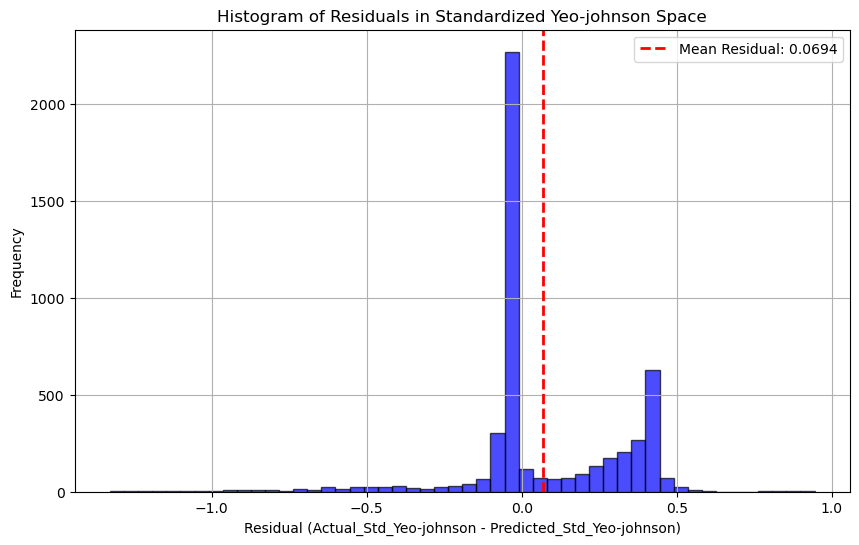

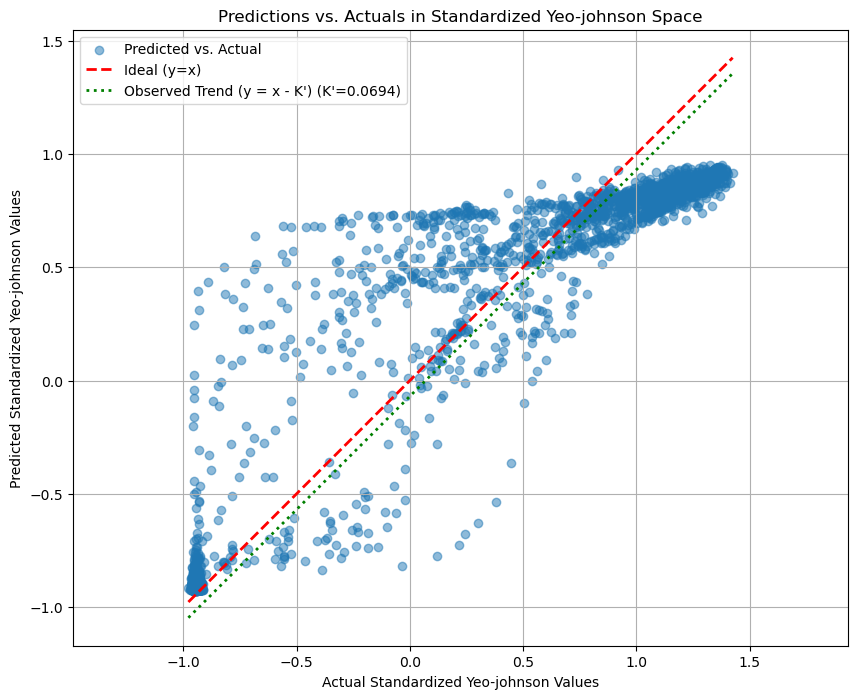


--- Scaled Metrics (Calculated in Evaluate Method) ---
Test RMSE (scaled): 0.265694
Test MAPE (scaled): 55.02%
Test MAPE (scaled, capped at 100% error per point): 19.53%

--- Calculating Original Scale Metrics ---
Applying inverse Yeo-Johnson transform (lambda=-0.1798) for column 'Radiation'
Applying inverse Yeo-Johnson transform (lambda=-0.1798) for column 'Radiation'
Test RMSE (original scale): 258.037522
Test MAPE (original scale): 56.47%
Test MAPE (original scale, capped at 100% error per point): 37.24%


In [8]:


# Evaluate on test data
model_predictions_std_log_np, actuals_std_log_np, predictions_original_scale, actuals_original_scale, metrics = model.evaluate(
        X_test, y_test,
    target_scaler_object=scalers["Radiation_yeo"],
    transform_info_dict=transform_info,  # Pass the complete transform_info
    )

# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions_original_scale - actuals_original_scale) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


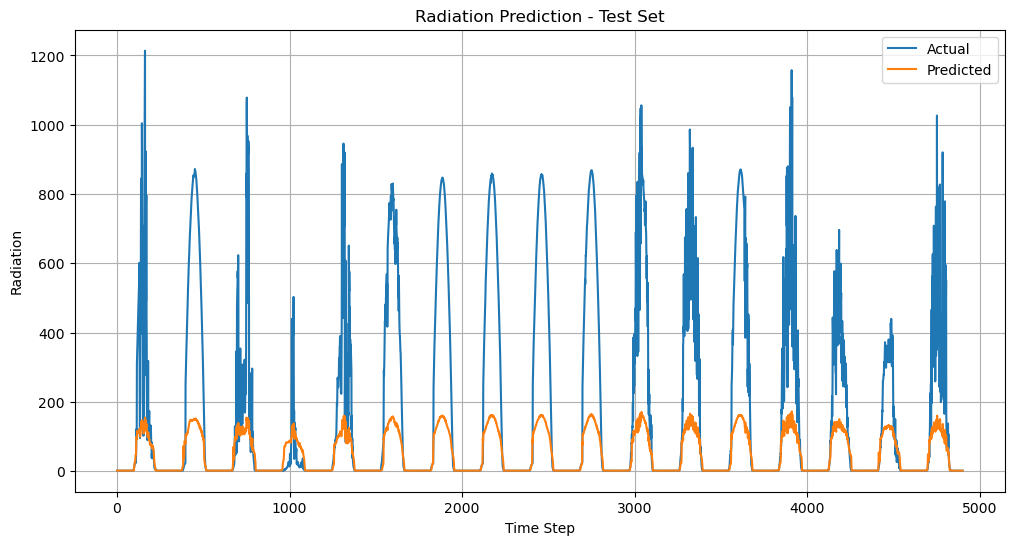

In [11]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals_original_scale, label='Actual')
plt.plot(predictions_original_scale, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

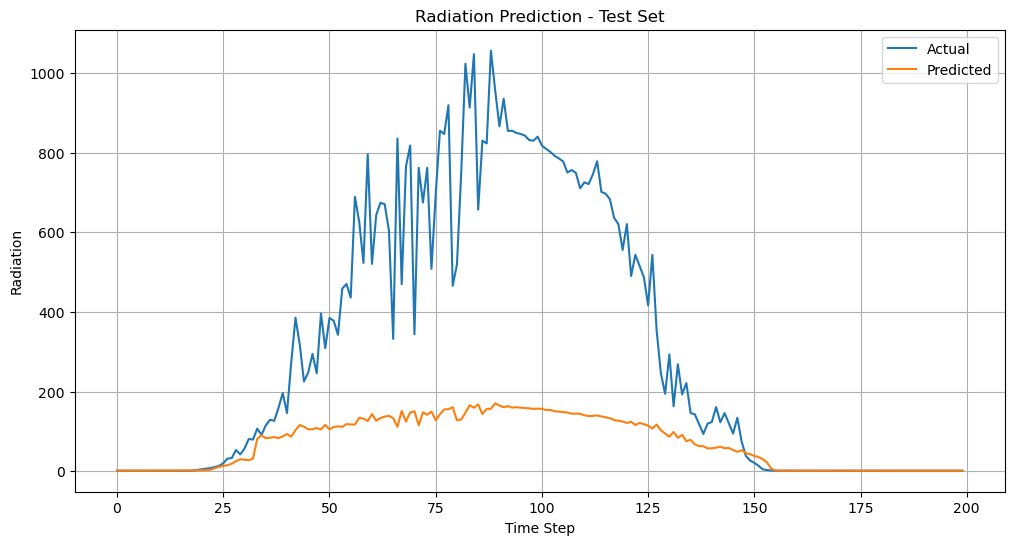

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_original_scale[2950:3150], label='Actual')
plt.plot(predictions_original_scale[2950:3150], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 4900, After resampling: 4900
Evaluation Summary:
Number of samples (after resampling): 4900
RMSE: 258.037522
MAE: 131.722015
MAPE: 56.47%
R²: 0.126192
Correlation: 0.903219


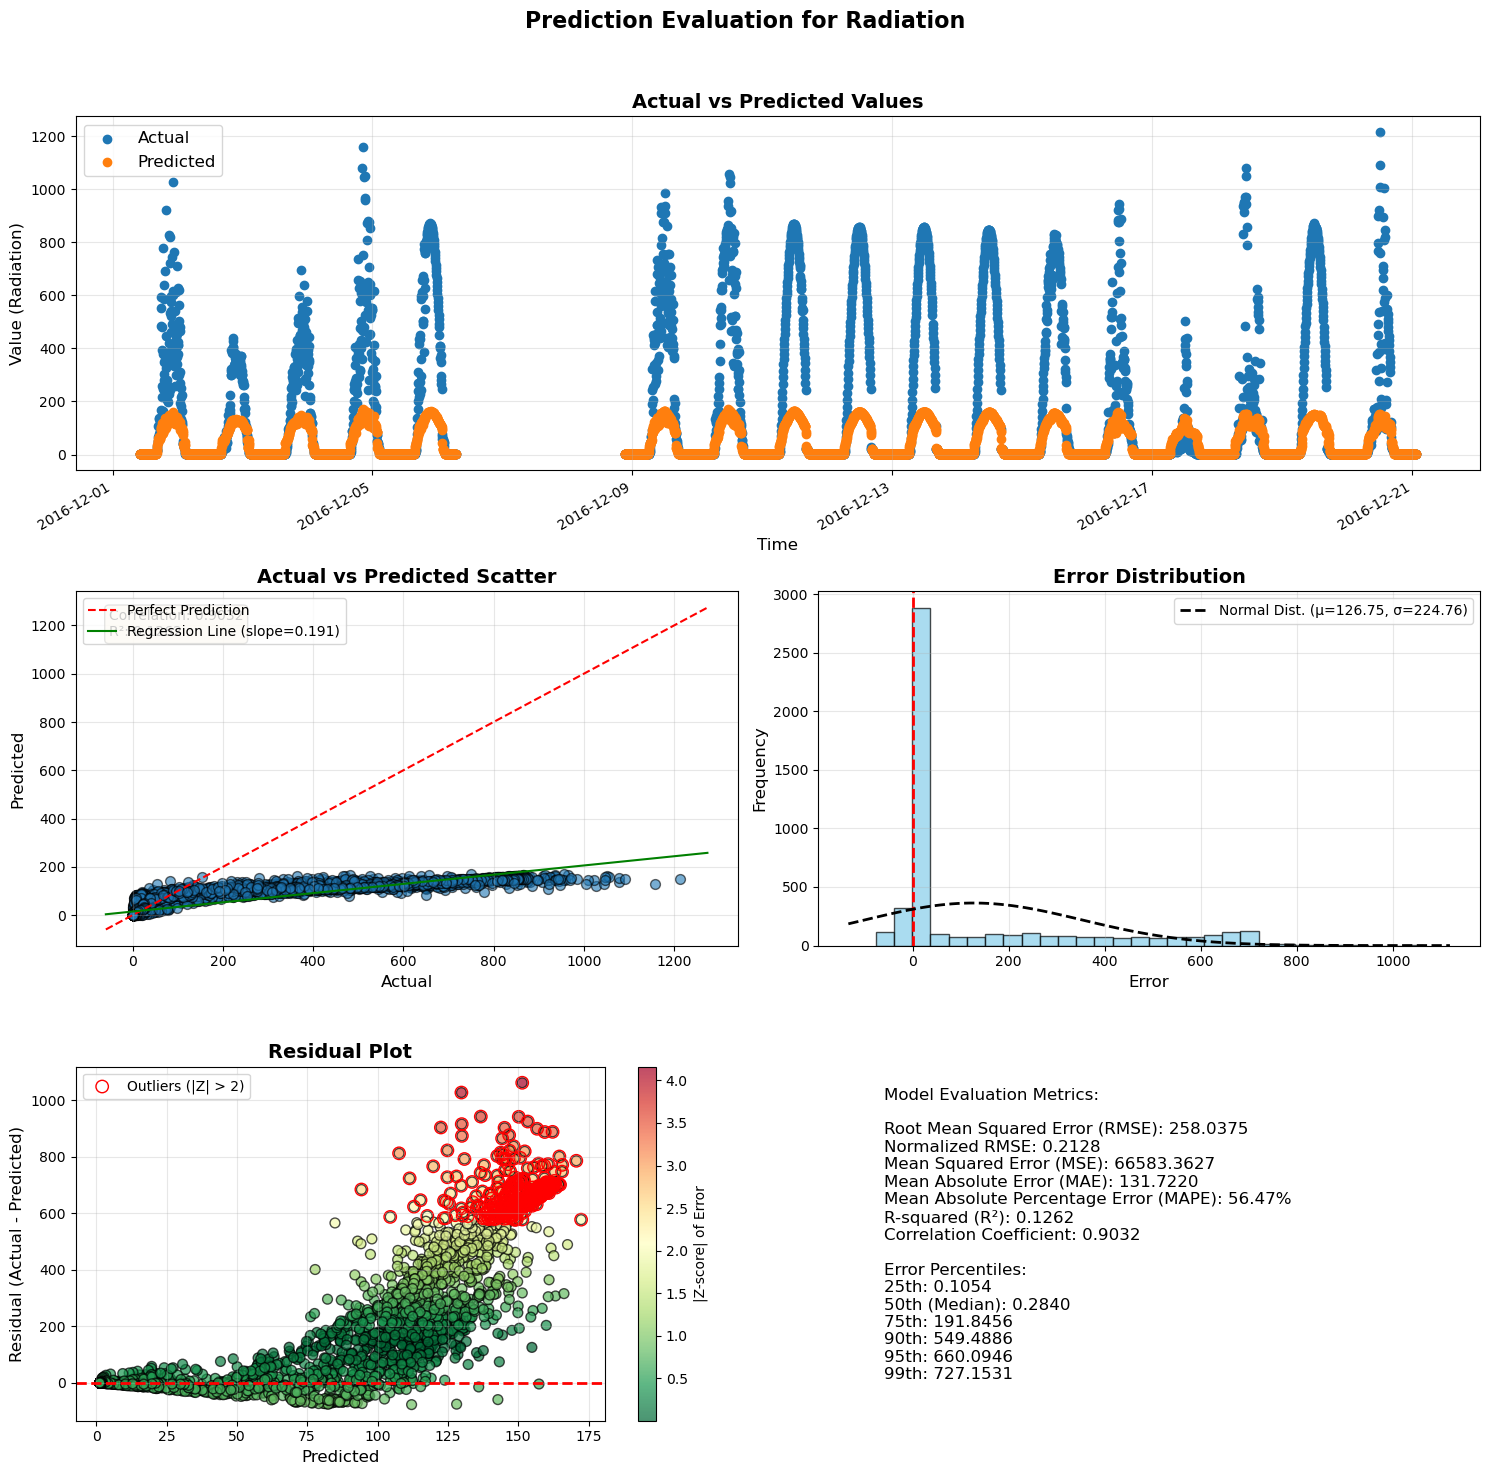

In [13]:
import plot_utils as pu 

# You can create timestamps if data has a time component
timestamps = df['UNIXTime'].values[-len(predictions_original_scale):]  # assuming UNIXTime exists in df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions_original_scale, 
    actuals=actuals_original_scale, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)


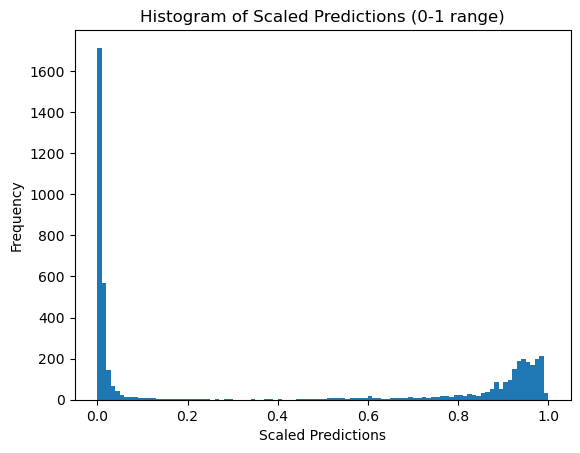

In [14]:
# Scale the data to [0,1] range
model_predictions_scaled = (model_predictions_std_log_np - model_predictions_std_log_np.min()) / (model_predictions_std_log_np.max() - model_predictions_std_log_np.min())

# Plot the scaled predictions
plt.hist(model_predictions_scaled, bins=100)
plt.title('Histogram of Scaled Predictions (0-1 range)')
plt.xlabel('Scaled Predictions')
plt.ylabel('Frequency')
plt.show()


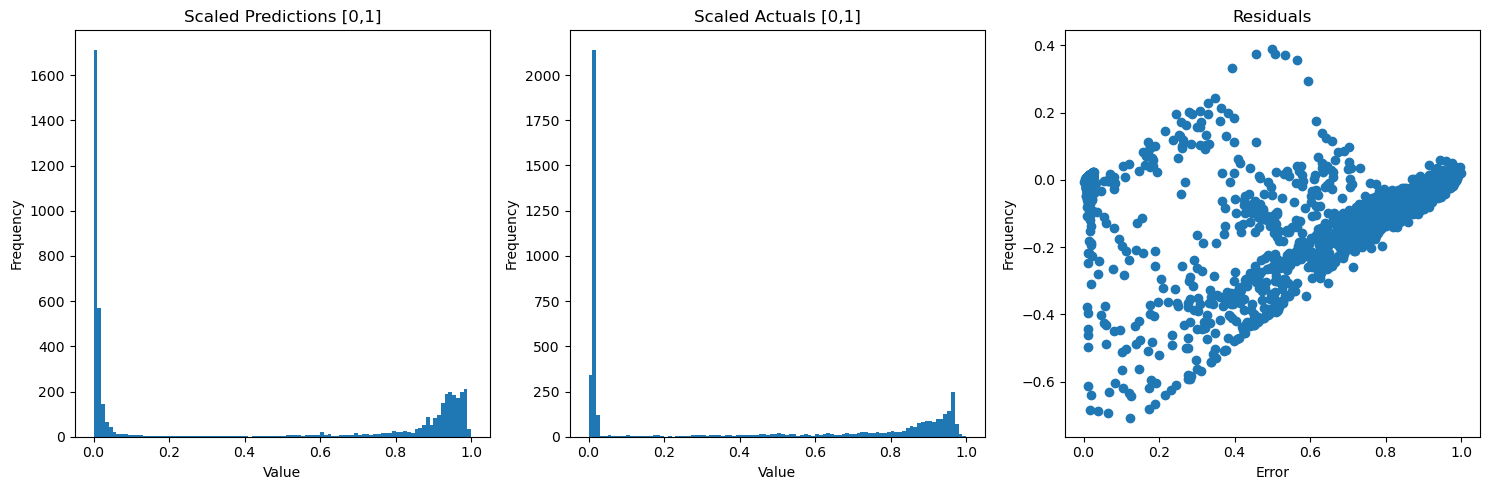


Scaled Data Statistics:
Predictions - Min: 0.0000, Max: 1.0000, Mean: 0.4132
Actuals    - Min: 0.0000, Max: 1.0000, Mean: 0.3731

Residuals Statistics:
Min: -0.7087, Max: 0.3902, Mean: -0.0401, Std: 0.1013


In [15]:
# Scale both predictions and actuals to [0,1] range
model_predictions_scaled = (model_predictions_std_log_np - model_predictions_std_log_np.min()) / (model_predictions_std_log_np.max() - model_predictions_std_log_np.min())
actuals_scaled = (actuals_std_log_np - actuals_std_log_np.min()) / (actuals_std_log_np.max() - actuals_std_log_np.min())

# Calculate residuals
residuals = actuals_scaled - model_predictions_scaled

# Plot histograms
plt.figure(figsize=(15, 5))

# Plot scaled predictions
plt.subplot(131)
plt.hist(model_predictions_scaled, bins=100)
plt.title('Scaled Predictions [0,1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot scaled actuals
plt.subplot(132)
plt.hist(actuals_scaled, bins=100)
plt.title('Scaled Actuals [0,1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot residuals
plt.subplot(133)
plt.scatter(actuals_scaled, residuals)
plt.title('Residuals')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nScaled Data Statistics:")
print(f"Predictions - Min: {model_predictions_scaled.min():.4f}, Max: {model_predictions_scaled.max():.4f}, Mean: {model_predictions_scaled.mean():.4f}")
print(f"Actuals    - Min: {actuals_scaled.min():.4f}, Max: {actuals_scaled.max():.4f}, Mean: {actuals_scaled.mean():.4f}")
print(f"\nResiduals Statistics:")
print(f"Min: {residuals.min():.4f}, Max: {residuals.max():.4f}, Mean: {residuals.mean():.4f}, Std: {residuals.std():.4f}")

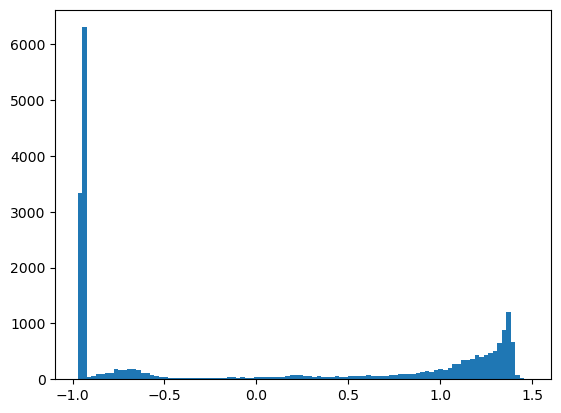

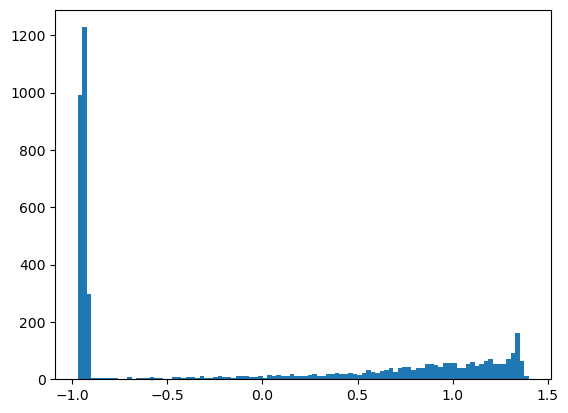

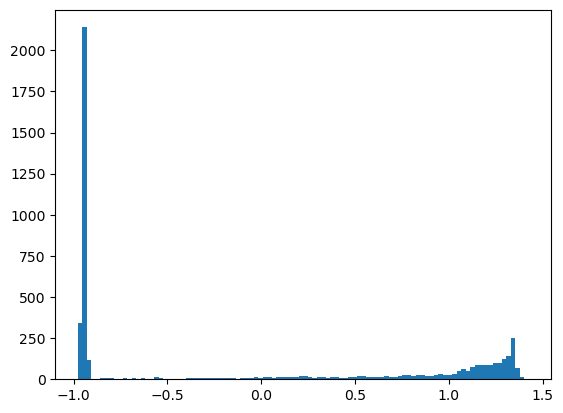

In [16]:
#plot histogram of y train
plt.hist(y_train, bins=100)
plt.show()

#plot histogram of y val
plt.hist(y_val, bins=100)
plt.show()

plt.hist(y_test, bins=100)
plt.show()


In [17]:
print(model.fc3.bias.item())
print(model.fc3.weight)


0.05188759043812752
Parameter containing:
tensor([[ 0.0440,  0.0779,  0.0657, -0.1508,  0.0867,  0.0483, -0.1137, -0.0989,
         -0.1305, -0.1771, -0.1345, -0.0787, -0.1681,  0.0413,  0.0677,  0.0932,
          0.0642, -0.2249, -0.1253, -0.0663,  0.0851,  0.0687,  0.0626, -0.1275,
         -0.1040,  0.1189, -0.1228,  0.0530, -0.0417, -0.1421, -0.0658, -0.1113,
         -0.0764,  0.0901,  0.0248, -0.0727,  0.0760,  0.0963,  0.0847,  0.0788,
          0.0533, -0.1137,  0.0575,  0.1734,  0.0216,  0.0386, -0.0894, -0.1245,
         -0.1394, -0.1412, -0.0945,  0.0420, -0.1333, -0.0939,  0.0621,  0.1086,
         -0.0506, -0.1381, -0.1390, -0.1117,  0.0327, -0.0649,  0.0585,  0.3722]],
       requires_grad=True)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [ ]:
model.save('weather_lstm_model.pt')

# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.